### Libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D

In [72]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import random
import sklearn
import time
import matplotlib.pyplot as plt
import os
import sys

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm import tqdm
from scipy import stats
from utils import *

### Experiment Setting

In [57]:

robot_choice = "4DoF-2RPR"
seed = True                                                                   # seed random generators for reproducibility
visualize_joints = True                                                       # visualize joint distribution in dataset     
visualize_workspace = True                                                    # visualize workspace (positions)
visualize_losses = True                                                       # visuallze training and validation losses
visualize_normalized_workspace = True                                         # visualize normalized workspace (positions - debugging purposes)
visualize_workspace_results = True                                            # visualize results in workapce
print_inference_summary = True                                                # perform and print inference summary after training is done
print_epoch = True                                                            # print epoch info during training and total training time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')         # device to train on
batch_size = 100                                                              # desired batch size
init_type = "default"                                                         # weights init method (default, uniform, normal, xavier_uniform, xavier_normal)
hidden_layer_sizes = [32,64,128,32]                                           # architecture to employ
learning_rate = 1e-4                                                          # learning rate
optimizer_choice = "SGD"                                                      # optimizers (SGD, Adam, Adadelta, RMSprop)
loss_choice = "l2"                                                            # l2, l1

EPOCHS = 10000                                                                # total training epochs


In [3]:
# ensure reproducibilities if seed is set to true
if seed:
    SEED = 3
    
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [4]:
if robot_choice == "4DoF-2RPR":
    n_DoF = 4
    input_dim = 3
    output_dim = 4
    
data = pd.read_csv('data_'+robot_choice+'_2.csv')
data

,x,y,z,t1,t2,t3,t4
0,-0.098194,0.139204,0.218765,1.559036,2.413440,0.031235,0.592730
1,-0.005284,0.233037,0.122378,0.965797,1.992017,0.127622,0.992976
2,-0.109576,0.206662,0.156266,1.431398,1.986449,0.093734,0.733938
3,0.373133,0.102294,0.169467,0.070138,0.530486,0.080533,0.795096
4,-0.146554,0.053330,0.201353,2.191788,2.513310,0.048647,0.671394
...,...,...,...,...,...,...,...
19995,0.071428,0.389194,0.187266,1.275780,0.303424,0.062734,0.683083
19996,-0.105358,0.376187,0.157960,1.676974,0.447431,0.092040,0.875621
19997,-0.107143,0.321314,0.214542,1.473924,1.163316,0.035458,0.824888
19998,-0.291024,0.168127,0.099525,2.190749,1.188748,0.150475,0.877858


[Text(0.5, 0, 'samples'), Text(0.5, 1.0, 'theta 4')]

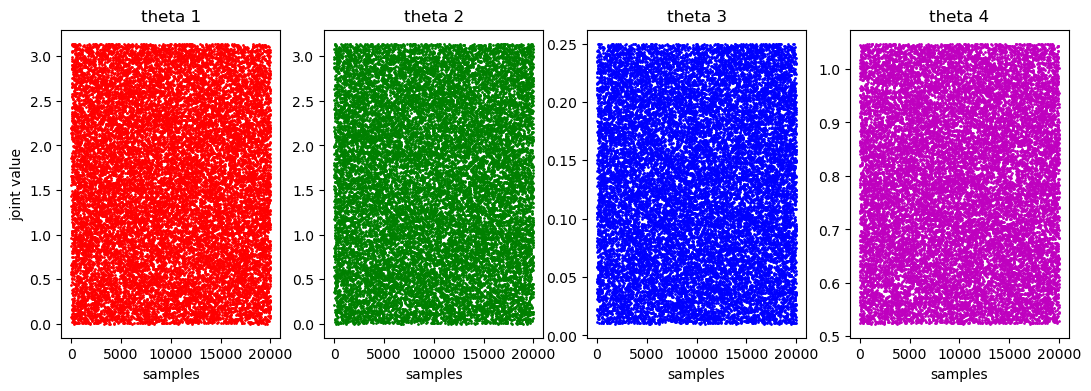

In [5]:
# visualize joints
data_a = np.array(data) 
n_samples = data_a.shape[0]
values = np.linspace(1,n_samples,n_samples)

if visualize_joints:
    """
    fig, axs = plt.subplots(1,4, figsize=(13, 4)) #, sharex=True, sharey=True)
    axs[0].scatter(values, data_a[:,6],s=1, marker='o', c='r')
    axs[0].set(xlabel='samples', ylabel='joint value', title='theta 1')
    axs[1].scatter(values, data_a[:,7],s=1, marker='o', c='g')
    axs[1].set(xlabel='samples', title='theta 2')
    axs[2].scatter(values, data_a[:,8],s=1, marker='o', c='b')
    axs[2].set(xlabel='samples', title='theta 3')
    axs[3].scatter(values, data_a[:,9],s=1, marker='o', c='m')
    axs[3].set(xlabel='samples', title='theta 4')
    """
    
    fig, axs = plt.subplots(1,4, figsize=(13, 4)) #, sharex=True, sharey=True)
    axs[0].scatter(values, data_a[:,3],s=1, marker='o', c='r')
    axs[0].set(xlabel='samples', ylabel='joint value', title='theta 1')
    axs[1].scatter(values, data_a[:,4],s=1, marker='o', c='g')
    axs[1].set(xlabel='samples', title='theta 2')
    axs[2].scatter(values, data_a[:,5],s=1, marker='o', c='b')
    axs[2].set(xlabel='samples', title='theta 3')
    axs[3].scatter(values, data_a[:,6],s=1, marker='o', c='m')
    axs[3].set(xlabel='samples', title='theta 4')


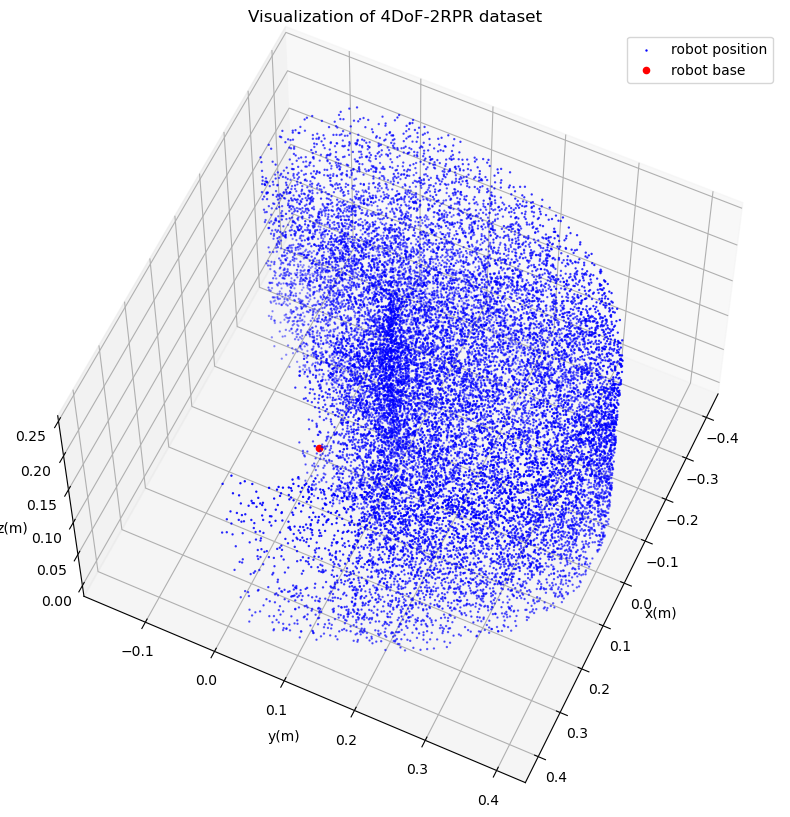

In [51]:
if visualize_workspace:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(data_a[:,0], data_a[:,1], data_a[:,2], s=2, c='b', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='r')
    ax.legend(["robot position","robot base"])
    ax.set(xlabel='x(m)', ylabel='y(m)', zlabel='z(m)',
           title='Visualization of '+robot_choice+ ' dataset')
    ax.view_init(60, 25)
    plt.show()

### Utilities (Classes and Functions)

In [7]:
# vanilla MLP architecture
class MLP_2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.name = "MLP[]"
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]
        batch_size = x.shape[0]
        
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred, h_2

class MLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "MLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        
        self.hidden_fc = nn.ModuleList()
        for i in range(len(self.h_sizes)-1):
            self.hidden_fc.append(nn.Linear(self.h_sizes[i], self.h_sizes[i+1]))
        
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], output_dim)

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        #x = self.batch_norm_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        for i in range(len(self.h_sizes)-1):
            x = self.hidden_fc[i](x)
            #x = self.batch_norm_fc(x)
            x = self.relu_activation(x)

        x = self.output_fc(x)
        x_temp = x

        return x, x_temp 


# count network parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# data loader
class LoadIKDataset(Dataset):
    def __init__(self, inputs_array, outputs_array):
        x_temp = inputs_array
        y_temp = outputs_array

        self.x_data = torch.tensor(x_temp, dtype=torch.float32) 
        self.y_data = torch.tensor(y_temp, dtype=torch.float32) 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        current_input = self.x_data[idx, :]
        current_output = self.y_data[idx, :]
        
        sample = {'input': current_input,
                  'output': current_output}
        return sample
    

    def __len__(self):
        return len(self.x_data)


# function to load the dataset
def load_dataset(data, n_DoF, batch_size):

    # file data_4DoF
    #X = data[:,:3]
    #y = data[:,6:]

    # file data_4DOF_2
    X = data[:,:3]
    y = data[:,3:]

        
    #y = data[:,:2]
    #X = data[:,2:]
        
    # split in train and test sets
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, 
                                                                y, 
                                                                test_size = 0.1,
                                                                random_state = 1)

    sc_in = MinMaxScaler(copy=True, feature_range=(-1, 1))
    sc_out = MinMaxScaler(copy=True, feature_range=(-1, 1))
    
    X_train = sc_in.fit_transform(X_train_i)
    X_test = sc_in.transform(X_test_i)  
    #X_train = X_train_i
    #X_test = X_test_i

    #y_train = sc_out.fit_transform(y_train)
    #y_test = sc_out.transform(y_test) 

    print(X_train.shape)
    print(y_train_i.shape)

    train_data = LoadIKDataset(X_train, y_train_i)
    test_data = LoadIKDataset(X_test, y_test_i)

    train_data_loader = DataLoader(dataset=train_data,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=False)

    test_data_loader = DataLoader(dataset=test_data,
                                   batch_size=1,
                                   shuffle=False)

    return train_data_loader, test_data_loader, X_test_i, y_test_i, X_train, y_train_i

# train function
def train(model, iterator, optimizer, criterion, batch_size, device, epoch, EPOCHS):
    epoch_loss = 0
    model.train()
    i = 0
    
    #with tqdm(total=(len(iterator) - len(iterator) % batch_size)) as t:
    with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
        for data in iterator:
        #for data in tqdm(iterator, desc="Training", leave=False):
            optimizer.zero_grad()
            x, y = data['input'], data['output']
            #print(x)
            #print(y)
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            """
            if i == 1:
                print("\nTrain Epoch {} at batch {}".format(epoch, i))
                print(y_pred[:5,:])
                print(y[:5,:])
                #sys.exit()
            """
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            t.set_postfix_str('Train loss: {:.6f}'.format(epoch_loss/len(iterator)))
            t.update()

            i += 1
    
    
    
    #print("Total batches {}".format(i))
        
    return epoch_loss/len(iterator)

# evaluation function 
def evaluate(model, iterator, criterion, device, epoch, EPOCHS):
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
        #for data in tqdm(iterator, desc="Evaluating", leave=False):        
        with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
            for data in iterator:
                x = data['input'].to(device)
                y = data['output'].to(device)
                y_pred, _ = model(x)
                loss = criterion(y_pred, y)
                epoch_loss += loss.item()
    
                t.set_postfix_str('Valid loss: {:.6f}'.format(epoch_loss/len(iterator)))
                t.update()

    return epoch_loss/len(iterator)

# make predictions
def inference(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        #X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    #X_desireds = np.array(X_desireds)
    X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    X_preds = reconstruct_pose(y_preds, robot_choice)

    X_errors = np.abs(X_preds- X_desireds)
    y_errors = np.abs(y_preds- y_desireds)

    X_errors_report = np.array([[X_errors.min(axis=0)],
                                [X_errors.mean(axis=0)],
                                [X_errors.max(axis=0)]]).squeeze()
    
    results = {
        "y_preds": y_preds,
        "X_preds": X_preds,
        "y_desireds": y_desireds,
        "X_desireds": X_desireds,
        "X_errors": X_errors_report
    }
    return results

def inference_FK(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    X_desireds = np.array(X_desireds)
    #X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    #X_preds = reconstruct_pose(y_preds, robot_choice)

    #X_errors = np.abs(X_preds - X_desireds)
    y_errors = np.abs(y_preds - y_desireds)

    y_errors_report = np.array([[y_errors.min(axis=0)],
                                [y_errors.mean(axis=0)],
                                [y_errors.max(axis=0)]]).squeeze()
    
    results = {
        "y_preds": y_preds,
        #"X_preds": X_preds,
        "y_desireds": y_desireds,
        #"X_desireds": X_desireds,
        "y_errors": y_errors_report
    }
    return results

# reconstruct positions in cartesian space from predictions
def reconstruct_pose(y_preds, robot_choice):
    y_preds = torch.from_numpy(y_preds)
    n_samples = y_preds.shape[0]
    pose = []
    for i in range(n_samples):
        t = y_preds[i,:]
        DH = get_DH(robot_choice, t)
        T = forward_kinematics(DH)
        if robot_choice == "4DoF-2RPR":
            # x,y,t1,t2,t3 where x,y (m) and t (rad)
            pose.append(T[:3,-1].numpy())
          
    X_pred = np.array(pose)
    return X_pred
    

# compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [8]:
# load the dataset
train_data_loader, test_data_loader, X_test, y_test, X_train, y_train = load_dataset(data_a, n_DoF, batch_size)

# get network architecture
model = MLP(input_dim, hidden_layer_sizes, output_dim)

if init_type == "uniform":
    model.apply(weights_init_uniform_rule)
elif init_type == "normal":
    model.apply(weights_init_normal_rule)
elif init_type == "xavier_uniform":
    model.apply(weights_init_xavier_uniform_rule)
elif init_type == "xavier_normal":
    model.apply(weights_init_xavier_normal_rule)
elif init_type == "kaiming_uniform":
    model.apply(weights_init_kaiming_uniform_rule)
elif init_type == "kaiming_normal":
    model.apply(weights_init_kaiming_normal_rule)
    
model = model.to(device)
print("==> Architecture: {}\n{}".format(model.name, model))
print("==> Trainable parameters: {}".format(count_parameters(model)))

(18000, 3)
(18000, 4)
==> Architecture: MLP [3, 32, 64, 128, 32, 4]
MLP(
  (input_fc): Linear(in_features=3, out_features=32, bias=True)
  (hidden_fc): ModuleList(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (output_fc): Linear(in_features=32, out_features=4, bias=True)
  (selu_activation): SELU()
  (relu_activation): ReLU()
  (prelu_activation): PReLU(num_parameters=1)
  (lrelu_activation): LeakyReLU(negative_slope=0.01)
  (sigmoid_activation): Sigmoid()
  (batch_norm_fc): BatchNorm1d(20000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
==> Trainable parameters: 54821


In [9]:
## train and validate


# set optimizer
if optimizer_choice == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
elif optimizer_choice == "Adam":
    optimizer = optim.Adam(model.parameters())
elif optimizer_choice == "Adadelta":
    optimizer = optim.Adadelta(model.parameters())
elif optimizer_choice == "RMSprop":
    optimizer = optim.RMSprop(model.parameters())

# set loss
if loss_choice == "l1":
    criterion = nn.MSELoss(reduction="mean")
elif loss_choice == "l2":
    criterion = nn.L1Loss(reduction="mean")


print("\n==> Training network: {}".format(model.name))


# create a directory to save weights
experiment_number = 1
save_path = robot_choice+"_" \
            +model.name.replace(" ","").replace("[","_").replace("]","_").replace(",","-") \
            +optimizer_choice+"_" \
            +loss_choice+"_" \
            +str(experiment_number)
if not os.path.exists(save_path):
    os.makedirs(save_path)

train_losses = []
valid_losses = []
best_valid_loss = float('inf')
start_time_train = time.monotonic()
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    train_loss = train(model, train_data_loader, optimizer, criterion, batch_size, device, epoch, EPOCHS)        
    valid_loss = evaluate(model, test_data_loader, criterion, device, epoch, EPOCHS)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path+'/best_epoch.pth')
        best_epoch = epoch
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch % (EPOCHS/10) == 0 or epoch == EPOCHS-1:
        if print_epoch:
            print('Epoch: {}/{} | Epoch Time: {}m {}s'.format(epoch, EPOCHS, epoch_mins, epoch_secs))
            print('\tTrain Loss: {}'.format(train_loss))
            print('\tValid Loss: {}'.format(valid_loss))
            print("\tBest Epoch Occurred [{}/{}]".format(best_epoch, EPOCHS))    
        torch.save(model.state_dict(), save_path+'/epoch_'+str(epoch)+'.pth')

end_time_train = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time_train, end_time_train)

if print_epoch:
    print('\nElapsed Time: {}m {}s'.format(epoch_mins, epoch_secs))    


==> Training network: MLP [3, 32, 64, 128, 32, 4]
Epoch: 0/10000 | Epoch Time: 0m 1s
	Train Loss: 1.5013510041766696
	Valid Loss: 1.3600552946366369
	Best Epoch Occurred [0/10000]
Epoch: 1000/10000 | Epoch Time: 0m 0s
	Train Loss: 0.011759088167713748
	Valid Loss: 0.011816187127165903
	Best Epoch Occurred [1000/10000]
Epoch: 2000/10000 | Epoch Time: 0m 0s
	Train Loss: 0.008764745080326167
	Valid Loss: 0.008861321257860254
	Best Epoch Occurred [2000/10000]
Epoch: 3000/10000 | Epoch Time: 0m 0s
	Train Loss: 0.007556796668925219
	Valid Loss: 0.0076958508744583015
	Best Epoch Occurred [3000/10000]
Epoch: 4000/10000 | Epoch Time: 0m 0s
	Train Loss: 0.006915420888819628
	Valid Loss: 0.007082534690056945
	Best Epoch Occurred [4000/10000]
Epoch: 5000/10000 | Epoch Time: 0m 0s
	Train Loss: 0.006580771161760721
	Valid Loss: 0.006769680214661094
	Best Epoch Occurred [5000/10000]
Epoch: 6000/10000 | Epoch Time: 0m 0s
	Train Loss: 0.006393079622648656
	Valid Loss: 0.006596399553808169
	Best Epoch 

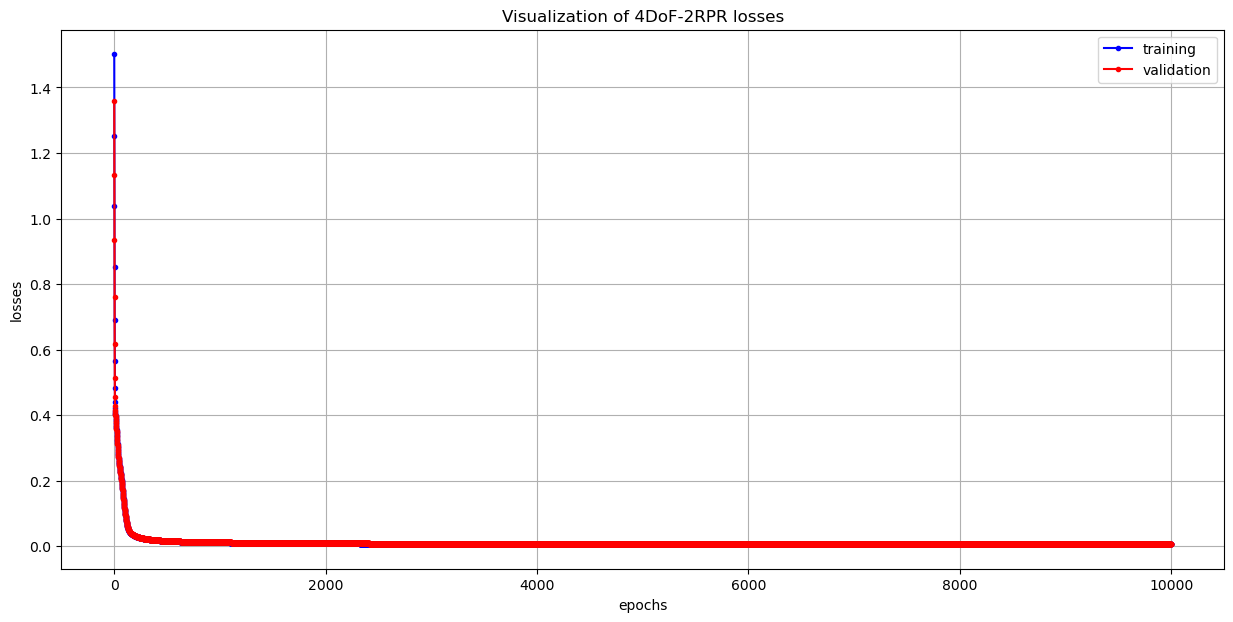

In [10]:
# visualize losses
if visualize_losses:
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(train_losses, marker='.', c='b')
    ax.plot(valid_losses, marker='.', c='r')
    ax.set(xlabel='epochs', ylabel='losses',
           title='Visualization of '+robot_choice+ ' losses')
    ax.legend(["training", "validation"])
    ax.grid()

In [43]:
# inference
if print_inference_summary:
    weights_file = save_path+"/best_epoch.pth"
    model = MLP(input_dim, hidden_layer_sizes, output_dim).to(device)
    
    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)
    
    # get the results from training
    
    results = inference(model, test_data_loader, criterion, device)
    y_preds = results["y_preds"]
    X_preds = results["X_preds"]
    y_desireds = results["y_desireds"]
    X_desireds = results["X_desireds"]
    X_errors = results["X_errors"]
    
    print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
    print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))
    
    print("==> X_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_preds.shape, X_preds.min(), X_preds.mean(), X_preds.max(), X_preds))
    print("==> X_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_test.shape, X_test.min(), X_test.mean(), X_test.max(), X_test))
    print("X_errors (mm): \n{}".format(X_errors*1000))

    #results = inference_FK(model, test_data_loader, criterion, device)
    #y_preds = results["y_preds"]
    #y_desireds = results["y_desireds"]
    #y_errors = results["y_errors"]
    
    #print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
    #print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))
    #print("y_errors (mm): \n{}".format(y_errors*1000))
    
    
    X_errors_p = np.abs(X_preds - X_desireds)*1000

==> y_preds (2000, 4): min = 0.0026 / mean = 1.0098 / max = 3.1702
[[1.879517   0.86990905 0.10376999 0.7870732 ]
 [0.0688813  2.592768   0.2359623  0.77548146]
 [2.1808577  0.5811157  0.11561911 0.783662  ]
 ...
 [3.0884883  0.32367882 0.05703425 0.7849383 ]
 [0.09440282 2.71329    0.01945446 0.7778758 ]
 [0.91215396 1.2393076  0.06961392 0.7869759 ]]

==> y_test (2000, 4): min = 0.0002 / mean = 1.0107 / max = 3.1415
[[1.8737766  0.8928162  0.10233442 1.0246218 ]
 [0.04758037 2.5810854  0.24421191 0.6087518 ]
 [2.177438   0.56510323 0.11486035 0.99578595]
 ...
 [3.0886009  0.30615577 0.06182919 0.7304791 ]
 [0.12227935 2.7124817  0.0148312  0.5730739 ]
 [0.9237403  1.2293764  0.07007358 0.6843534 ]]

==> X_preds (2000, 3): min = -0.3981 / mean = 0.0720 / max = 0.3991
[[-0.21457249  0.2955095   0.14623001]
 [ 0.11635397  0.08646603  0.0140377 ]
 [-0.28255033  0.26048824  0.1343809 ]
 ...
 [-0.3941902  -0.02682295  0.19296575]
 [ 0.1071711   0.07272515  0.23054555]
 [ 0.07072389  0.3231

In [47]:
if print_inference_summary:
    # percentage of errors less than 1mm, 5mm, 10mm (1cm), 15mm (1.5cm), 20mm (2cm)
    X_percentile = stats.percentileofscore(X_errors_p[:,0], [1,5,10,15,20], kind='rank')
    Y_percentile = stats.percentileofscore(X_errors_p[:,1], [1,5,10,15,20], kind='rank')
    Z_percentile = stats.percentileofscore(X_errors_p[:,2], [1,5,10,15,20], kind='rank')
    print("X_percentile: {}".format(X_percentile))
    print("Y_percentile: {}".format(Y_percentile))
    print("Z_percentile: {}".format(Z_percentile))

X_percentile: [ 24.55  86.5   98.65  99.85 100.  ]
Y_percentile: [25.6  85.65 98.45 99.55 99.7 ]
Z_percentile: [21.6  76.75 95.95 99.3  99.75]


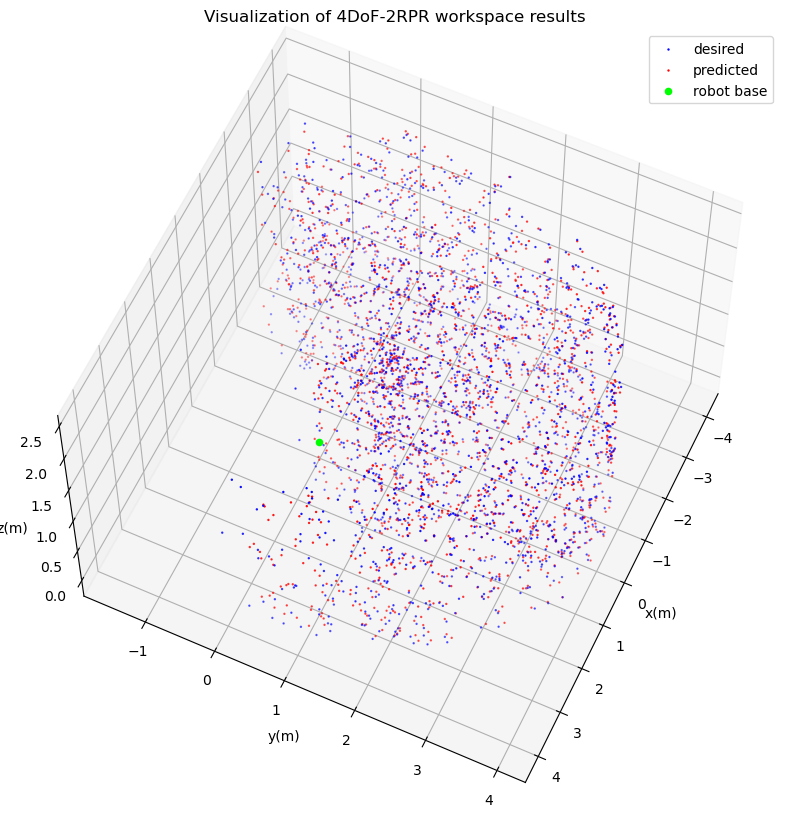

In [56]:
if visualize_workspace_results:
    X_desireds = X_desireds*1000
    X_preds = X_preds*1000    
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_desireds[:,0], X_desireds[:,1], X_desireds[:,2], s=2, c='b', marker='.')
    ax.scatter(X_preds[:,0], X_preds[:,1], X_preds[:,2], s=2, c='r', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='lime')
    ax.legend(["desired", "predicted", "robot base"])
    ax.set(xlabel='x(m)', ylabel='y(m)', zlabel='z(m)',
           title='Visualization of '+robot_choice+ ' workspace results')
    ax.view_init(60, 25)
    plt.show()

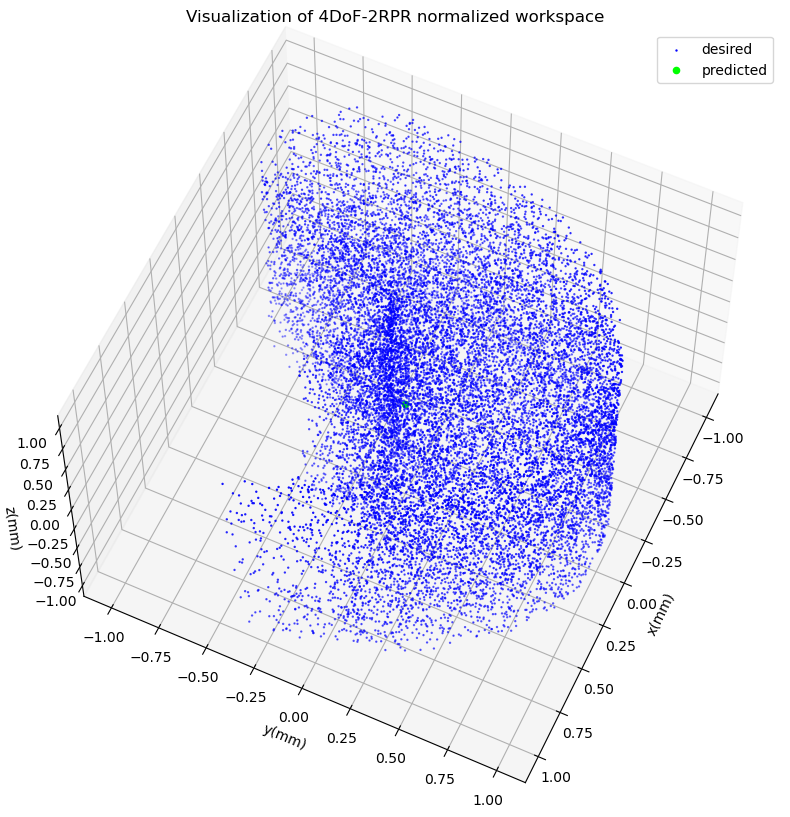

In [59]:
if visualize_normalized_workspace:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], s=2, c='b', marker='.')
    ax.scatter(0,0,0,s=20, marker='o', c='lime')
    ax.legend(["desired", "predicted", "robot base"])
    ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
           title='Visualization of '+robot_choice+ ' normalized workspace')
    ax.view_init(60, 25)
    plt.show()